In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def get_data(path):
    df = pd.read_hdf(path)
    data = df[(df.ValueDateTime.dt.year == 2022) & (df.ValueDateTime.dt.month == 1) & (df.ValueDateTime.dt.week == 1)]
    data['TimeDelta_h'] = (data['ValueDateTime'] - data['ForecastDateTime']).astype('timedelta64[h]').astype(int)
    data['TimeDelta_d'] = data['TimeDelta_h']/24
    return data

In [236]:
BEL = get_data("Temp/BEL_TEMP_GEFS.h5");
ITA = get_data("Temp/ITA_TEMP_EC15.h5");
DEU_EC15 = get_data("Temp/DEU_TEMP_EC15.h5");
DEU_GEFS = get_data("Temp/DEU_TEMP_GEFS.h5");

<ipython-input-2-c800c2ab819f>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data = df[(df.ValueDateTime.dt.year == 2022) & (df.ValueDateTime.dt.month == 1) & (df.ValueDateTime.dt.week == 1)]
<ipython-input-2-c800c2ab819f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TimeDelta_h'] = (data['ValueDateTime'] - data['ForecastDateTime']).astype('timedelta64[h]').astype(int)
<ipython-input-2-c800c2ab819f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

ValueError: Wrong number of items passed 9, placement implies 1

In [14]:
BEL

,ForecastDateTime,ObservationDateTime,PointConnectCurveId,ValueDateTime,source,value,ens_num,TimeDelta_h,TimeDelta_d
1012015,2021-12-18 00:00:00,2021-12-18 10:00:00,101649438,2022-01-03 00:00:00,Redshift,-0.36,0,384,16.00
1038963,2021-12-18 06:00:00,2021-12-18 16:00:00,101649438,2022-01-03 00:00:00,Redshift,-3.11,0,378,15.75
1074330,2021-12-18 12:00:00,2021-12-18 22:00:00,101649438,2022-01-03 00:00:00,Redshift,-1.11,0,372,15.50
1113183,2021-12-18 18:00:00,2021-12-19 04:00:00,101649438,2022-01-03 00:00:00,Redshift,3.69,0,366,15.25
1053435,2021-12-19 00:00:00,2021-12-19 10:00:00,101649438,2022-01-03 00:00:00,Redshift,7.69,0,360,15.00
...,...,...,...,...,...,...,...,...,...
140213,2022-01-08 18:00:00,2022-01-09 04:00:00,120171385,2022-01-09 18:00:00,Redshift,3.64,30,24,1.00
147822,2022-01-09 00:00:00,2022-01-09 10:00:00,120171385,2022-01-09 18:00:00,Redshift,3.64,30,18,0.75
122455,2022-01-09 06:00:00,2022-01-09 16:00:00,120171385,2022-01-09 18:00:00,Redshift,3.45,30,12,0.50
31030,2022-01-09 12:00:00,2022-01-09 22:00:00,120171385,2022-01-09 18:00:00,Redshift,3.15,30,6,0.25


In [22]:
BEL.groupby(["ValueDateTime", "TimeDelta_h"])["value"].quantile(0.05).reset_index()

,ValueDateTime,TimeDelta_h,value
0,2022-01-03 00:00:00,0,10.60
1,2022-01-03 00:00:00,6,10.30
2,2022-01-03 00:00:00,12,10.00
3,2022-01-03 00:00:00,18,10.20
4,2022-01-03 00:00:00,24,9.86
...,...,...,...
1815,2022-01-09 18:00:00,360,-1.34
1816,2022-01-09 18:00:00,366,-0.94
1817,2022-01-09 18:00:00,372,-2.94
1818,2022-01-09 18:00:00,378,-0.99


In [529]:
def get_bounds(data, α, horizon):
    dataNew = data[(data.TimeDelta_h==0) & (data.ens_num==0)]["value"].reset_index()
    dataMean = data.groupby(["ValueDateTime", "TimeDelta_h"])["value"].mean().reset_index()
    dataMean = dataMean[dataMean.TimeDelta_h==horizon]
    dataStd = data.groupby(["ValueDateTime", "TimeDelta_h"])["value"].std().reset_index()
    dataStd = dataStd[dataStd.TimeDelta_h==horizon]
    data_α = data.groupby(["ValueDateTime", "TimeDelta_h"])["value"].quantile(α).reset_index()
    data_α = data_α[data_α.TimeDelta_h==horizon]
    data_1_minus_α = data.groupby(["ValueDateTime", "TimeDelta_h"])["value"].quantile(1-α).reset_index()
    data_1_minus_α = data_1_minus_α[data_1_minus_α.TimeDelta_h==horizon]
    dataNew['ValueDateTime'] = dataMean['ValueDateTime'].values
    dataNew['+1std'] = dataNew['value'] + dataStd['value'].values
    dataNew['-1std'] = dataNew['value'] - dataStd['value'].values
    dataNew['α'] = data_α['value'].values
    dataNew['1-α'] = data_1_minus_α['value'].values
    dataNew['mean'] = dataMean['value'].values
    return dataNew

In [494]:
Belgium = get_bounds(BEL, 0.05, 24);
Italy = get_bounds(ITA, 0.05, 24);
Ger_EC15 = get_bounds(DEU_EC15, 0.05, 24);
Ger_GEFS = get_bounds(DEU_GEFS, 0.05, 24);

In [495]:
Belgium

,index,value,ValueDateTime,+1std,-1std,α,1-α,mean
0,1088069,10.85,2022-01-03 00:00:00,11.204965,10.495035,11.06,9.86,10.410000
1,1001106,10.38,2022-01-03 06:00:00,10.697009,10.062991,10.55,9.50,10.137097
2,1038640,10.18,2022-01-03 12:00:00,10.757201,9.602799,11.15,9.35,10.337097
3,156349,9.98,2022-01-03 18:00:00,10.352466,9.607534,10.35,9.20,9.833871
4,1003172,8.78,2022-01-04 00:00:00,9.322119,8.237881,10.55,8.70,9.604839
5,1006704,7.78,2022-01-04 06:00:00,8.562881,6.997119,9.18,7.33,8.289677
6,1095136,9.18,2022-01-04 12:00:00,10.900440,7.459560,10.23,5.13,8.328387
7,1096924,6.78,2022-01-04 18:00:00,8.009617,5.550383,7.98,4.18,5.773548
8,1035697,4.28,2022-01-05 00:00:00,4.946882,3.613118,4.83,2.73,3.796129
9,1014854,2.52,2022-01-05 06:00:00,3.041660,1.998340,4.03,2.33,3.109032


In [496]:
def plot_bounds(dfs, horizon):
    for df in dfs:
        fig, ax = plt.subplots(figsize=(20,10))
        # True values
        plt.plot(df[df.TimeDelta_h==0]["ValueDateTime"], df[df.TimeDelta_h==0]["value"], label='True value', color="black") 
        plt.plot(
            df[df.TimeDelta_h==horizon]["ValueDateTime"],
            df[df.TimeDelta_h==horizon]["value"], 
            label="forecast"
        )
        p1 = plt.fill_between(
            df[df.TimeDelta_h==horizon]["ValueDateTime"], 
            df[df.TimeDelta_h==horizon]["+1std"],
            df[df.TimeDelta_h==horizon]["-1std"], alpha=0.2, color="r")
        p2 = plt.fill_between(
            df[df.TimeDelta_h==horizon]["ValueDateTime"], 
            df[df.TimeDelta_h==horizon]["α"],
            df[df.TimeDelta_h==horizon]["1-α"], alpha=0.2)

        ax.set_ylabel("Temperature", fontsize = 16)
        ax.set_xlabel("Forecast date", fontsize = 15)

        ax.set_title("Different bounds", fontsize = 15)
        ax.legend(fontsize = 15)
        ax.grid('on')
        plt.show()

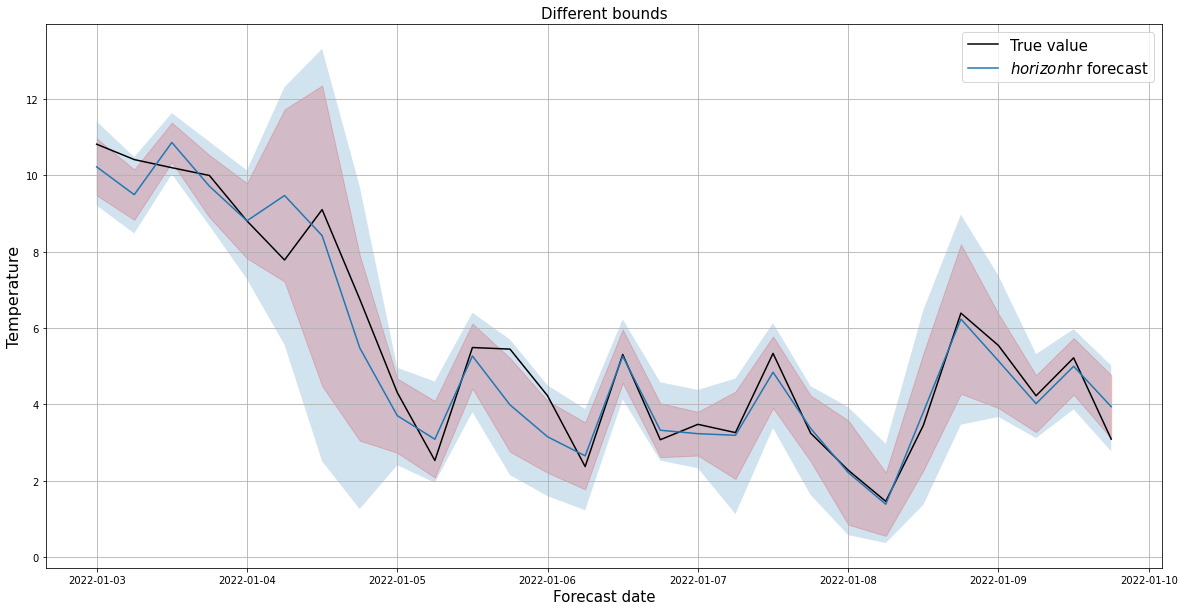

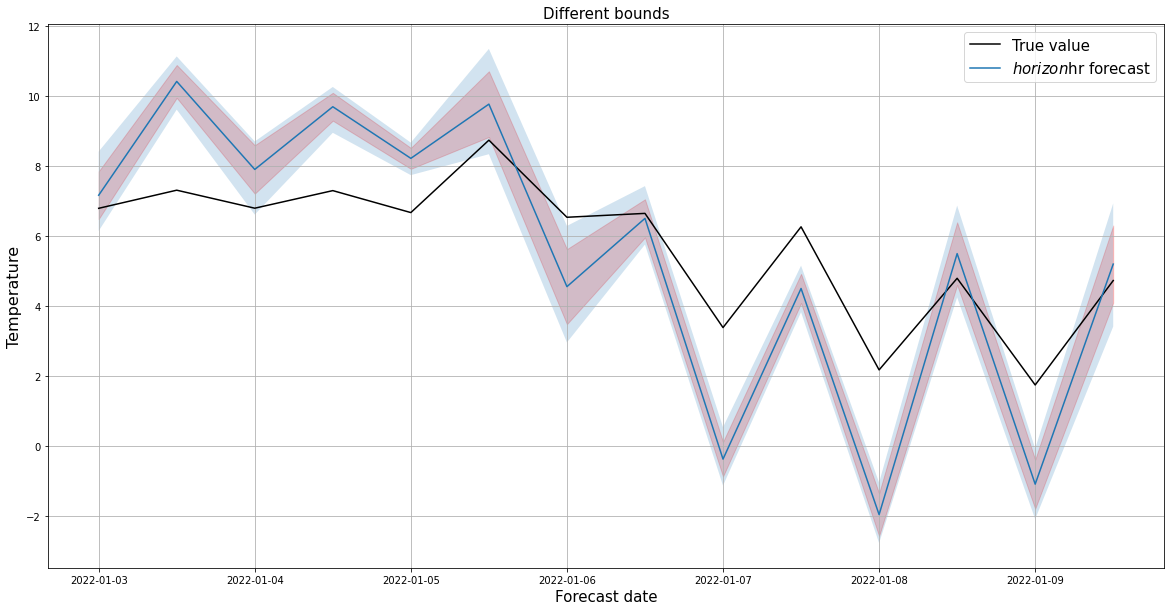

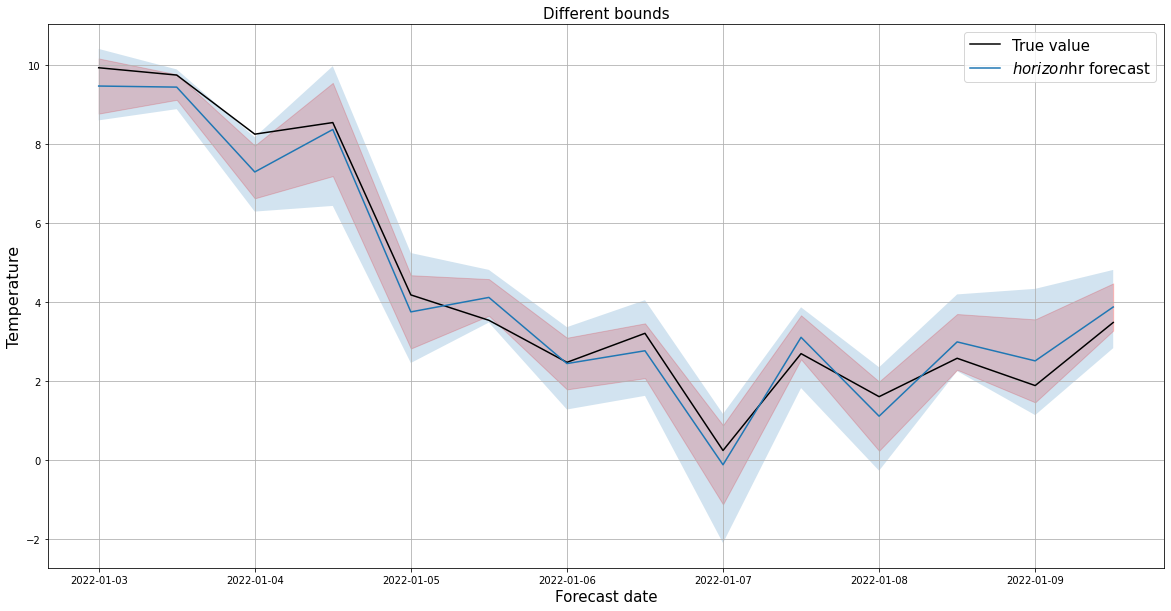

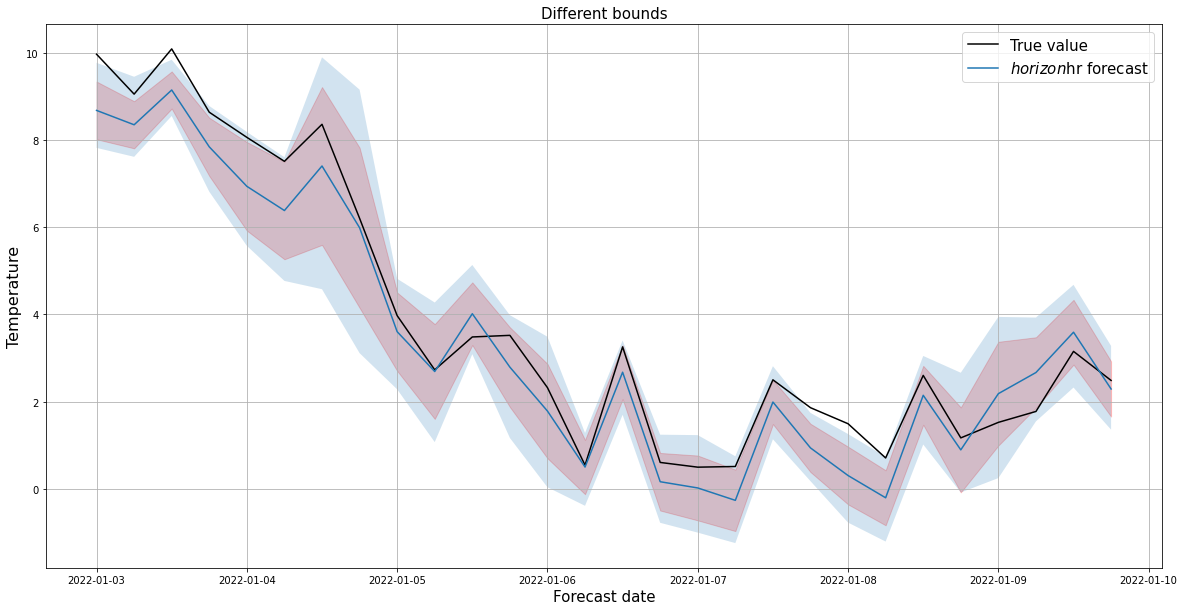

In [51]:
plot_bounds([Belgium, Italy, Ger_EC15, Ger_GEFS], 72)

In [532]:
# See https://otexts.com/fpp3/distaccuracy.html
def winkler(df, α, horizon):
    df = get_bounds(df, α, horizon);
    score = 0
    for vdt in df.ValueDateTime:
        if df[df.ValueDateTime==vdt]["α"].values[0] <= df[df.ValueDateTime==vdt]["value"].values[0] <= df[df.ValueDateTime==vdt]["1-α"].values[0]:
            val = df[df.ValueDateTime==vdt]["1-α"] - df[df.ValueDateTime==vdt]["α"]
            score += val.values[0]
        elif df[df.ValueDateTime==vdt]["α"].values[0] > df[df.ValueDateTime==vdt]["value"].values[0]:
            val = df[df.ValueDateTime==vdt]["1-α"] - df[df.ValueDateTime==vdt]["α"] + 2/α*(df[df.ValueDateTime==vdt]["α"]-df[df.ValueDateTime==vdt]["value"])
            score += val.values[0]
        else:
            val = df[df.ValueDateTime==vdt]["1-α"] - df[df.ValueDateTime==vdt]["α"] + 2/α*(df[df.ValueDateTime==vdt]["value"]-df[df.ValueDateTime==vdt]["1-α"])
            score += val.values[0]
        
    return score


In [539]:
winkler(BEL, 0.05, 6)

$
$
$
$
$
$
$
$
$


135.89999999999998